<a href="https://colab.research.google.com/github/liutsumin/real-data-test/blob/master/Image_Event_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Event Anomaly Detection
This program will deal with a task in Computer Vision (CV) using unsupervised learning -- Image Anomaly Detection.

### Download Dataset & Pretrained Model

In [ ]:
## Download training data, testing data, and pretrained models
!gdown --id '1STAbOipGCctj0S6a_IMBDhyi5K-uRGxm' --output data.zip
!gdown --id '1MwBJmgY9VIRFT-hoqjWdMmTI7F9qy29P' --output pretrained.zip
!unzip data.zip
!unzip pretrained.zip
!rm data.zip
!rm pretrained.zip

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1STAbOipGCctj0S6a_IMBDhyi5K-uRGxm
To: /content/data.zip
100% 226M/226M [00:02<00:00, 78.9MB/s]
/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1MwBJmgY9VIRFT-hoqjWdMmTI7F9qy29P
To: /content/pretrained.zip
100% 510M/510M [00:06<00:00, 85.0MB/s]
Archive:  data.zip
   creating: dataset/
   creating: dataset/Test_png/
   creating: dataset/Test_png/Test004/
  inflating: dataset/Test_png/Test004/001.png  
  inflating: dataset/Test_png/Test004/002.png  
  inflating: dataset/Test_png/Test004/003.png

### Import Some Packages

In [ ]:
import os, glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.utils.data as data
import torchvision.transforms as T
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim.lr_scheduler import ReduceLROnPlateau


### Fixed random seed
Fix random seed to ensure that the result can be reproduced.

In [ ]:
def fixed_seed(myseed):
  np.random.seed(myseed)
  random.seed(myseed)
  torch.manual_seed(myseed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True
  if torch.cuda.is_available():
      torch.cuda.manual_seed_all(myseed)
      torch.cuda.manual_seed(myseed)

myseed = 20221011
fixed_seed(myseed)

## Custom Dataset

In [ ]:
class Anomaly_dataset(data.Dataset):
  def __init__(self, root, transform=None, time_step=1):
    self.time_step = time_step

    dirs = sorted(os.listdir(root))
    self.img_paths = []
    for dir in dirs:
      img_paths_in_dir = sorted(glob.glob(os.path.join(root, dir) + "/*.png"))
      self.img_paths.append(img_paths_in_dir)

    self.img_pairs = self.setup_pair()

    self.size = len(self.img_pairs)
    self.transform = transform

  def __getitem__(self, index):
    img = self.load_img(self.img_pairs, index)
    img_path = self.img_pairs[index][-1]

    return img, img_path

  def load_img(self, imgs_list, index):
    imgs = []
    for img_path in imgs_list[index]:
        img = Image.open(img_path).convert('RGB')
        if(self.transform is not None):
            img = self.transform(img)
            imgs.append(img[0])
        else:
            imgs.append(img)
    if(self.transform is not None):
        imgs = torch.stack(imgs)
    return imgs
  
  def setup_pair(self):
    img_pairs = []
    for i in range(len(self.img_paths)):
        for j in range(len(self.img_paths[i])):
            if(j < self.time_step-1):
                pairs = [self.img_paths[i][0] for k in range(self.time_step-j)] + self.img_paths[i][1:j+1]
            else:
                pairs = self.img_paths[i][j-self.time_step+1:j+1]
            img_pairs.append(pairs)

    return img_pairs

  def __len__(self):
    return self.size

In [ ]:
transform = T.Compose([
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])
dataset = Anomaly_dataset(root='dataset/Train_png', transform=transform, time_step=8)
train_loader = DataLoader(dataset, batch_size=2, num_workers=0)
data_iter = iter(train_loader)
img, path = data_iter.next()
print(img.shape, path)   

torch.Size([2, 8, 240, 360]) ('dataset/Train_png/Train001/001.png', 'dataset/Train_png/Train001/002.png')


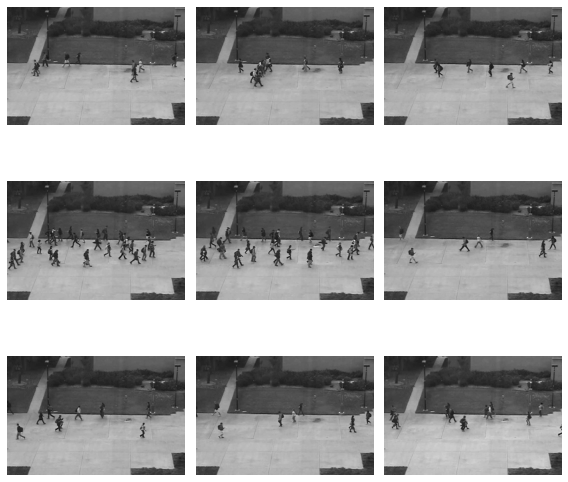

In [ ]:
nrows = 3
ncols = 3

# Shuffle the datasets
indices = np.arange(len(dataset))
np.random.shuffle(indices)
indices = indices[:nrows*ncols]
dataset = [ dataset[i] for i in indices ]

# Plot some data
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 8))

for i in range(nrows):
  for j in range(ncols):
    img = np.array(dataset[i*ncols+j][0][0])
    axes[i][j].imshow(img, cmap='gray')
    axes[i][j].set_axis_off()

plt.tight_layout()

## Some Useful functions

In [ ]:
def save_checkpoint(checkpoint_path, model, optimizer, best_loss, epoch):
    checkpoint = {
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict(),
      'best_loss': best_loss,
      'epoch': epoch,
    }
    torch.save(checkpoint, checkpoint_path)

# Plot training curve
def plot_curve(train_loss, val_loss):
    # Loss curve
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('Loss')
    plt.legend(['train', 'val'])
    plt.savefig('loss.png')
    plt.show()

# Transform imgs to video
def imgs2video(path, save_path):
  img_names = glob.glob(os.path.join(path, '*.png'))
  img_names.sort(key=lambda x:int(x.split('/')[-1].split('.')[0]))

  fps = 10
  size = cv2.imread(img_names[0]).shape[0:2][::-1]
  out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'MP4V'), fps, size)

  ## make video
  for img_name in img_names:
      rimg = cv2.imread(img_name)
      out.write(rimg)
      
  out.release()

# Convolution module
def conv(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
	modules = nn.Sequential(
		nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
		nn.BatchNorm2d(out_channels),
		nn.LeakyReLU(0.1),
		nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
		nn.BatchNorm2d(out_channels),
		nn.LeakyReLU(0.1)
	)

	return modules

## Validation Stage
def Validation(model, criterion, valid_loader):
    total_loss = 0
    pbar = tqdm(valid_loader, leave=True, desc="Val")

    model.eval()
    with torch.no_grad():
      for idx, (imgs, imgs_name) in enumerate(pbar):
        imgs = imgs.to(DEVICE)

        imgs_recons = model(imgs)
        loss = criterion(imgs_recons, imgs)

        total_loss += loss.item()
      
        pbar.set_postfix(
          loss=total_loss / (idx+1)
        )
    return total_loss / len(valid_loader)

## Training Stage
def Training(params, model, train_loader, valid_loader, criterion, optimizer, scheduler):
    best_loss = 100
    n_epochs = params["n_epochs"]

    patience = 0
    train_loss, valid_loss = [], []
    for epoch in range(n_epochs):
        total_loss, total_data = 0, 0
        pbar = tqdm(train_loader, leave=True, desc=f"Train[{epoch+1}/{n_epochs}]")

        model.train()
        for idx, (imgs, imgs_name) in enumerate(pbar):
            imgs = imgs.to(DEVICE)
            imgs_recons = model(imgs)

            loss = criterion(imgs_recons, imgs)

            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(
              lr= optimizer.param_groups[0]['lr'],
              loss= total_loss / (idx+1)
            )
        
        val_loss = Validation(model, criterion, valid_loader)

        if(val_loss < best_loss):
            best_loss = val_loss
            best_epoch = epoch
            checkpoint_path = os.path.join(params["model_dir"], 'best.pth')
            save_checkpoint(checkpoint_path, model, optimizer, best_loss, epoch)
            patience = 0
        else:
            patience += 1
        checkpoint_path = os.path.join(params["model_dir"], 'last.pth')
        save_checkpoint(checkpoint_path, model, optimizer, best_loss, epoch)

        if patience >= params["early_stop"]:
            print("Early Stop!!")
            break
        print(f"Best Loss at epoch{best_epoch}  | loss:{best_loss:.4f}")
        scheduler.step(val_loss)

        # Record loss
        valid_loss.append(val_loss)
        train_loss.append(total_loss / len(train_loader))
    print("----------- End training -----------")
    print(f"Best Loss at epoch{best_epoch}  | loss:{best_loss:.4f}")
    return train_loss, valid_loss

def Testing(model, test_loader, video_path="./video_AE", threshold=0.35):
    with torch.no_grad():
        for imgs, imgs_path in tqdm(test_loader):
            imgs = imgs.to(DEVICE)
            imgs_recons = model(imgs)

            for img, img_recons, img_path in zip(imgs, imgs_recons, imgs_path):
                img = img[-1].detach().cpu().numpy()
                img_recons = img_recons[-1].detach().cpu().numpy()

                img = (img*0.5+0.5)*255
                img_recons = (img_recons*0.5+0.5)*255

                dif = np.abs((img_recons-img))

                abnormal = np.where(dif > threshold*255, 1, 0)

                img = img.astype(np.uint8)
                img_recons = img_recons.astype(np.uint8)
                dif = dif.astype(np.uint8)

                img_name = img_path.split('/')[-1]

                cv2.imwrite(os.path.join(video_path, 'ori', img_name), img)
                cv2.imwrite(os.path.join(video_path, 'recons', img_name), img_recons)
                cv2.imwrite(os.path.join(video_path, 'diff', img_name), dif)

                img_result = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
                pos_x, pos_y = np.where(abnormal==1)
                for x, y in zip(pos_x, pos_y):
                    cv2.circle(img_result, (y, x), 1, (0, 0, 255), -1)
                cv2.imwrite(os.path.join(video_path, 'output', img_name), img_result)

## AutoEncoder

### Model
Build your own AutoEncoder model

In [ ]:
class AutoEncoder(nn.Module):
	def __init__(self, drop_rate=0., in_channels=1, out_channels=1):
		super(AutoEncoder, self).__init__()
		self.encoder = nn.Sequential(
			conv(in_channels, 8, 3, 1, 1),
			nn.MaxPool2d(2),
			nn.Dropout(drop_rate),

			conv(8, 64, 3, 1, 1),
			nn.MaxPool2d(2),
			nn.Dropout(drop_rate),

			conv(64, 256, 3, 1, 1),
			nn.MaxPool2d(2),
			nn.Dropout(drop_rate),
		)

		self.decoder = nn.Sequential(
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
			conv(256, 64, 3, 1, 1),
			nn.Dropout(drop_rate),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
			conv(64, 16, 3, 1, 1),
			nn.Dropout(drop_rate),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
			conv(16, out_channels, 3, 1, 1),
			nn.Tanh()
		)

	def forward(self, x):
		out = self.encoder(x)
		out = self.decoder(out)
		return out

### Main (Training)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

params = {
    "model_dir": "./model_AE",
    "val_split": 0.2,
    "batch_size": 32,
    "lr": 2e-4,
    "weight_decay": 1e-4,
    "n_epochs": 10,
    "early_stop": 10,
    "time_step": 1
}

os.makedirs(params["model_dir"], exist_ok = True)

transform = T.Compose([
  T.RandomResizedCrop((240, 360), scale=(0.8, 1), ratio=(0.9, 1.1)),
  T.RandomHorizontalFlip(p=0.5),
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])

dataset = Anomaly_dataset(root='dataset/Train_png', transform=transform, time_step=params["time_step"])

## Split dataset to training data & validation data
validation_split = params["val_split"]
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

print(f'Size of training data: {len(train_indices)}')
print(f'Size of validation data: {len(val_indices)}')

## Use SubsetRandomSampler to sample data from only training set or validation set
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=params["batch_size"], num_workers=2, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=params["batch_size"], num_workers=2, sampler=valid_sampler)

model = AutoEncoder(in_channels=params["time_step"], out_channels=params["time_step"]).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
criterion = nn.L1Loss(reduction="mean").to(DEVICE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

train_loss, valid_loss = Training(params, model, train_loader, valid_loader, criterion, optimizer, scheduler)

Size of training data: 2040
Size of validation data: 510


Val: 100%|██████████| 16/16 [00:02<00:00,  5.40it/s, loss=1.97e+4]


Best Loss at epoch0  | loss:19720.5195


Val: 100%|██████████| 16/16 [00:02<00:00,  5.62it/s, loss=1.91e+4]


Best Loss at epoch1  | loss:19051.4782


Val: 100%|██████████| 16/16 [00:02<00:00,  5.52it/s, loss=1.89e+4]


Best Loss at epoch2  | loss:18881.3643


Val: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=1.83e+4]


Best Loss at epoch3  | loss:18283.8333


Val: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=1.84e+4]


Best Loss at epoch3  | loss:18283.8333


Val: 100%|██████████| 16/16 [00:02<00:00,  5.65it/s, loss=1.81e+4]


Best Loss at epoch5  | loss:18111.1643


Val: 100%|██████████| 16/16 [00:03<00:00,  5.22it/s, loss=1.81e+4]


Best Loss at epoch5  | loss:18111.1643


Val: 100%|██████████| 16/16 [00:02<00:00,  5.73it/s, loss=1.8e+4]


Best Loss at epoch7  | loss:18001.0392


Val: 100%|██████████| 16/16 [00:02<00:00,  5.56it/s, loss=1.79e+4]


Best Loss at epoch8  | loss:17925.5364


Val: 100%|██████████| 16/16 [00:02<00:00,  5.64it/s, loss=1.78e+4]


Best Loss at epoch9  | loss:17780.4957
----------- End training -----------
Best Loss at epoch9  | loss:17780.4957


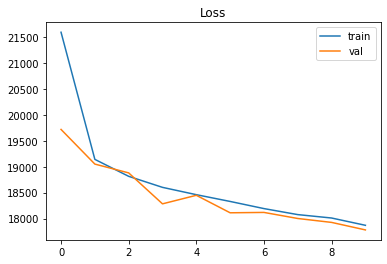

In [ ]:
plot_curve(train_loss, valid_loss)

### Main (Testing)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

transform = T.Compose([
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])


video_path = './video_AE'
test_dataset = Anomaly_dataset(root='dataset/Test_png', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

model = AutoEncoder(in_channels=params["time_step"], out_channels=params["time_step"]).to(DEVICE)
model_path = './Pretrained_models/AE.pth'
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model = model.eval()

os.makedirs('%s/ori' % video_path, exist_ok = True)
os.makedirs('%s/recons' % video_path, exist_ok = True)
os.makedirs('%s/diff' % video_path, exist_ok = True)
os.makedirs('%s/output' % video_path, exist_ok = True)

Testing(model, test_loader, video_path=video_path, threshold=0.35)

100%|██████████| 6/6 [00:03<00:00,  1.99it/s]


In [ ]:
imgs2video(os.path.join(video_path, "ori"), os.path.join(video_path, "ori.mp4"))
imgs2video(os.path.join(video_path, "recons"), os.path.join(video_path, "recons_AE.mp4"))
imgs2video(os.path.join(video_path, "diff"), os.path.join(video_path, "diff_AE.mp4"))
imgs2video(os.path.join(video_path, "output"), os.path.join(video_path, "output_AE.mp4"))

In [ ]:
# Download the predicted results to local
from google.colab import files
!zip -r video_AE.zip video_AE
files.download("video_AE.zip")

In [ ]:
!rm video_AE.zip
!rm -r video_AE

## Spatial CNN

### Model

In [ ]:
class AutoEncoder(nn.Module):
	def __init__(self, drop_rate=0., in_channels=1, out_channels=1):
		super(AutoEncoder, self).__init__()
		self.encoder = nn.Sequential(
			conv(in_channels, 16, 3, 1, 1),
			nn.MaxPool2d(2),
			nn.Dropout(drop_rate),

			conv(16, 64, 3, 1, 1),
			nn.MaxPool2d(2),
			nn.Dropout(drop_rate),

			conv(64, 256, 3, 1, 1),
			nn.MaxPool2d(2),
			nn.Dropout(drop_rate),
		)

		self.decoder = nn.Sequential(
			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
			conv(256, 64, 3, 1, 1),
			nn.Dropout(drop_rate),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
			conv(64, 16, 3, 1, 1),
			nn.Dropout(drop_rate),

			nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
			conv(16, out_channels, 3, 1, 1),
			nn.Tanh()
		)

	def forward(self, x):
		out = self.encoder(x)
		out = self.decoder(out)
		return out

### Main (Training)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

params = {
    "model_dir": "./model_SpatialAE",
    "val_split": 0.2,
    "batch_size": 32,
    "lr": 2e-4,
    "weight_decay": 1e-4,
    "n_epochs": 10,
    "early_stop": 10,
    "time_step": 8
}

os.makedirs(params["model_dir"], exist_ok = True)

transform = T.Compose([
  T.RandomResizedCrop((240, 360), scale=(0.8, 1), ratio=(0.9, 1.1)),
  T.RandomHorizontalFlip(p=0.5),
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])

dataset = Anomaly_dataset(root='dataset/Train_png', transform=transform, time_step=params["time_step"])

## Split dataset to training data & validation data
validation_split = params["val_split"]
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

print(f'Size of training data: {len(train_indices)}')
print(f'Size of validation data: {len(val_indices)}')

## Use SubsetRandomSampler to sample data from only training set or validation set
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=params["batch_size"], num_workers=2, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=params["batch_size"], num_workers=2, sampler=valid_sampler)

model = AutoEncoder(in_channels=params["time_step"], out_channels=params["time_step"]).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
criterion = nn.L1Loss(reduction="mean").to(DEVICE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

train_loss, valid_loss = Training(params, model, train_loader, valid_loader, criterion, optimizer, scheduler)

Size of training data: 2040
Size of validation data: 510


Train[1/10]:   3%|▎         | 2/64 [00:03<01:59,  1.92s/it, loss=0.458, lr=0.0002]


KeyboardInterrupt: ignored

In [ ]:
plot_curve(train_loss, valid_loss)

### Main (Testing)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

transform = T.Compose([
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])


video_path = './video_spatialAE'
test_dataset = Anomaly_dataset(root='dataset/Test_png', transform=transform, time_step=8)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

model = AutoEncoder(in_channels=params["time_step"], out_channels=params["time_step"]).to(DEVICE)
model_path = './Pretrained_models/SpatialAE.pth'
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model = model.eval()

os.makedirs('%s/ori' % video_path, exist_ok = True)
os.makedirs('%s/recons' % video_path, exist_ok = True)
os.makedirs('%s/diff' % video_path, exist_ok = True)
os.makedirs('%s/output' % video_path, exist_ok = True)

Testing(model, test_loader, video_path=video_path, threshold=0.35)

100%|██████████| 6/6 [00:06<00:00,  1.12s/it]


In [ ]:
imgs2video(os.path.join(video_path, "ori"), os.path.join(video_path, "ori.mp4"))
imgs2video(os.path.join(video_path, "recons"), os.path.join(video_path, "recons_AE.mp4"))
imgs2video(os.path.join(video_path, "diff"), os.path.join(video_path, "diff_AE.mp4"))
imgs2video(os.path.join(video_path, "output"), os.path.join(video_path, "output_AE.mp4"))

In [ ]:
# Download the predicted results to local
from google.colab import files
!zip -r video_spatialAE.zip video_spatialAE
files.download("video_spatialAE.zip")

  adding: video_spatialAE/ (stored 0%)
  adding: video_spatialAE/output_AE.mp4 (deflated 0%)
  adding: video_spatialAE/diff/ (stored 0%)
  adding: video_spatialAE/diff/064.png (deflated 0%)
  adding: video_spatialAE/diff/045.png (deflated 0%)
  adding: video_spatialAE/diff/133.png (deflated 0%)
  adding: video_spatialAE/diff/094.png (deflated 0%)
  adding: video_spatialAE/diff/005.png (deflated 0%)
  adding: video_spatialAE/diff/160.png (deflated 0%)
  adding: video_spatialAE/diff/125.png (deflated 0%)
  adding: video_spatialAE/diff/095.png (deflated 0%)
  adding: video_spatialAE/diff/076.png (deflated 0%)
  adding: video_spatialAE/diff/031.png (deflated 0%)
  adding: video_spatialAE/diff/020.png (deflated 0%)
  adding: video_spatialAE/diff/114.png (deflated 0%)
  adding: video_spatialAE/diff/072.png (deflated 0%)
  adding: video_spatialAE/diff/001.png (deflated 1%)
  adding: video_spatialAE/diff/075.png (deflated 0%)
  adding: video_spatialAE/diff/052.png (deflated 0%)
  adding: video

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm video_spatialAE.zip
!rm -r video_spatialAE

## LSTM

### Model

In [ ]:
class CNNLSTM(nn.Module):
  def __init__(self, drop_rate=0.1, in_channels=1, out_channels=1):
    super(CNNLSTM, self).__init__()
    self.encoder = nn.Sequential(
      conv(in_channels, 8, 3, 1, 1),
      nn.MaxPool2d(2),
      nn.Dropout(drop_rate),

      conv(8, 16, 3, 1, 1),
      nn.MaxPool2d(2),
      nn.Dropout(drop_rate),

      conv(16, 32, 3, 1, 1),
      nn.MaxPool2d(2),
      nn.Dropout(drop_rate),
    )

    self.rnn = nn.LSTM(
      input_size=1350,
      hidden_size=1350,
      num_layers=3,
      batch_first=True,
      dropout=drop_rate
    )

    self.decoder = nn.Sequential(
      nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
      conv(32, 16, 3, 1, 1),
      nn.Dropout(drop_rate),

      nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
      conv(16, 8, 3, 1, 1),
      nn.Dropout(drop_rate),

      nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
      conv(8, out_channels, 3, 1, 1),
      nn.Tanh()
    )

  def forward(self, x):
    out = self.encoder(x)

    b, c, w, h = out.shape
    out = torch.flatten(out, start_dim=2)
    out, _ = self.rnn(out, None)
    out = torch.reshape(out, (b, c, w, h))
    
    out = self.decoder(out)
    return out

### Main (Training)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

params = {
    "model_dir": "./model_LSTM",
    "val_split": 0.2,
    "batch_size": 32,
    "lr": 2e-4,
    "weight_decay": 1e-4,
    "n_epochs": 10,
    "early_stop": 10,
    "time_step": 8
}

os.makedirs(params["model_dir"], exist_ok = True)

transform = T.Compose([
  T.RandomResizedCrop((240, 360), scale=(0.8, 1), ratio=(0.9, 1.1)),
  T.RandomHorizontalFlip(p=0.5),
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])

dataset = Anomaly_dataset(root='dataset/Train_png', transform=transform, time_step=params["time_step"])

## Split dataset to training data & validation data
validation_split = params["val_split"]
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

print(f'Size of training data: {len(train_indices)}')
print(f'Size of validation data: {len(val_indices)}')

## Use SubsetRandomSampler to sample data from only training set or validation set
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=params["batch_size"], num_workers=2, sampler=train_sampler)
valid_loader = DataLoader(dataset, batch_size=params["batch_size"], num_workers=2, sampler=valid_sampler)

model = CNNLSTM(in_channels=params["time_step"], out_channels=params["time_step"]).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=params["lr"], weight_decay=params["weight_decay"])
criterion = nn.L1Loss(reduction="mean").to(DEVICE)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.7, patience=5)

train_loss, valid_loss = Training(params, model, train_loader, valid_loader, criterion, optimizer, scheduler)

Size of training data: 2040
Size of validation data: 510


Val: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s, loss=0.252]


Best Loss at epoch0  | loss:0.2517


Val: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s, loss=0.227]


Best Loss at epoch1  | loss:0.2272


Train[3/10]:  50%|█████     | 32/64 [00:32<00:32,  1.02s/it, loss=0.228, lr=0.0002]


KeyboardInterrupt: ignored

In [ ]:
plot_curve(train_loss, valid_loss)

### Main (Testing)

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else "cpu")

transform = T.Compose([
  T.Grayscale(),
  T.ToTensor(),
  T.Normalize(mean=(0.5,), std=(0.5,)),
])


video_path = './video_LSTM'
test_dataset = Anomaly_dataset(root='dataset/Test_png', transform=transform, time_step=8)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, shuffle=False)

model = CNNLSTM(in_channels=params["time_step"], out_channels=params["time_step"]).to(DEVICE)
model_path = './Pretrained_models/LSTM.pth'
checkpoint = torch.load(model_path, map_location=DEVICE)
model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)
model = model.eval()

os.makedirs('%s/ori' % video_path, exist_ok = True)
os.makedirs('%s/recons' % video_path, exist_ok = True)
os.makedirs('%s/diff' % video_path, exist_ok = True)
os.makedirs('%s/output' % video_path, exist_ok = True)

Testing(model, test_loader, video_path=video_path, threshold=0.5)

100%|██████████| 6/6 [00:05<00:00,  1.07it/s]


In [ ]:
imgs2video(os.path.join(video_path, "ori"), os.path.join(video_path, "ori.mp4"))
imgs2video(os.path.join(video_path, "recons"), os.path.join(video_path, "recons_AE.mp4"))
imgs2video(os.path.join(video_path, "diff"), os.path.join(video_path, "diff_AE.mp4"))
imgs2video(os.path.join(video_path, "output"), os.path.join(video_path, "output_AE.mp4"))

In [ ]:
# Download the predicted results to local
from google.colab import files
!zip -r video_LSTM.zip video_LSTM
files.download("video_LSTM.zip")

  adding: video_LSTM/ (stored 0%)
  adding: video_LSTM/output_AE.mp4 (deflated 0%)
  adding: video_LSTM/diff/ (stored 0%)
  adding: video_LSTM/diff/064.png (deflated 0%)
  adding: video_LSTM/diff/045.png (deflated 0%)
  adding: video_LSTM/diff/133.png (deflated 0%)
  adding: video_LSTM/diff/094.png (deflated 0%)
  adding: video_LSTM/diff/005.png (deflated 0%)
  adding: video_LSTM/diff/160.png (deflated 0%)
  adding: video_LSTM/diff/125.png (deflated 0%)
  adding: video_LSTM/diff/095.png (deflated 0%)
  adding: video_LSTM/diff/076.png (deflated 0%)
  adding: video_LSTM/diff/031.png (deflated 0%)
  adding: video_LSTM/diff/020.png (deflated 0%)
  adding: video_LSTM/diff/114.png (deflated 0%)
  adding: video_LSTM/diff/072.png (deflated 0%)
  adding: video_LSTM/diff/001.png (deflated 0%)
  adding: video_LSTM/diff/075.png (deflated 0%)
  adding: video_LSTM/diff/052.png (deflated 0%)
  adding: video_LSTM/diff/172.png (deflated 0%)
  adding: video_LSTM/diff/091.png (deflated 0%)
  adding: vide

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!rm video_LSTM.zip
!rm -r video_LSTM